In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
df = []
stock_name = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df.append(pd.read_csv(os.path.join(dirname, filename),index_col = 0) )
        stock_name.append(filename)
        #print(dirname)
        #print(filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# index_col = 0 makes the Date column as the index else it was 0,1,2...

In [2]:
df[10].head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-06-18,11.03,11.03,11.03,11.03,10.198853,0
2012-06-19,11.03,11.03,11.03,11.03,10.198853,0
2012-06-20,11.03,11.03,11.03,11.03,10.198853,0
2012-06-21,11.03,11.03,11.03,11.03,10.198853,0
2012-06-22,11.03,11.03,11.03,11.03,10.198853,0


In [3]:
stock_name[100]

'717503.BO.csv'

In [4]:
df[100].shape

(1565, 6)

In [5]:
df[100].describe()

,Open,High,Low,Close,Adj Close,Volume
count,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1.565000e+03
mean,7.959144,8.005802,7.929335,7.966709,6.051756,1.969206e+06
std,1.755859,1.757981,1.758535,1.753638,1.079812,6.176801e+06
min,2.480000,2.850000,2.480000,2.850000,2.726316,0.000000e+00
25%,7.600000,7.630000,7.580000,7.600000,5.217708,2.318600e+04
50%,8.400000,8.500000,8.400000,8.400000,6.140487,2.759070e+05
75%,9.250000,9.300000,9.210000,9.260000,6.763847,1.361068e+06
max,11.000000,11.000000,10.000000,10.100000,7.803689,9.816484e+07


In [6]:
df[100].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1565 entries, 2014-03-19 to 2020-06-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1565 non-null   float64
 1   High       1565 non-null   float64
 2   Low        1565 non-null   float64
 3   Close      1565 non-null   float64
 4   Adj Close  1565 non-null   float64
 5   Volume     1565 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 85.6+ KB


Text(0.5, 1.0, 'Closing Price of 717503.BO.csv')

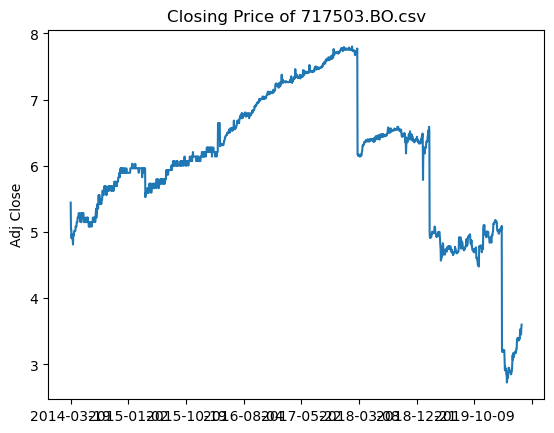

In [7]:
df[100]["Adj Close"].plot()
plt.ylabel("Adj Close")
plt.xlabel(None)
plt.title(f"Closing Price of {stock_name[100]}")

In [8]:
ma_day = [10, 50, 100, 365]

for ma in ma_day:
    for company in df:
        column_name = f"MA for {ma} days"
        #Rolling calculates mean over ma days in time series
        company[column_name] = company["Adj Close"].rolling(ma).mean()

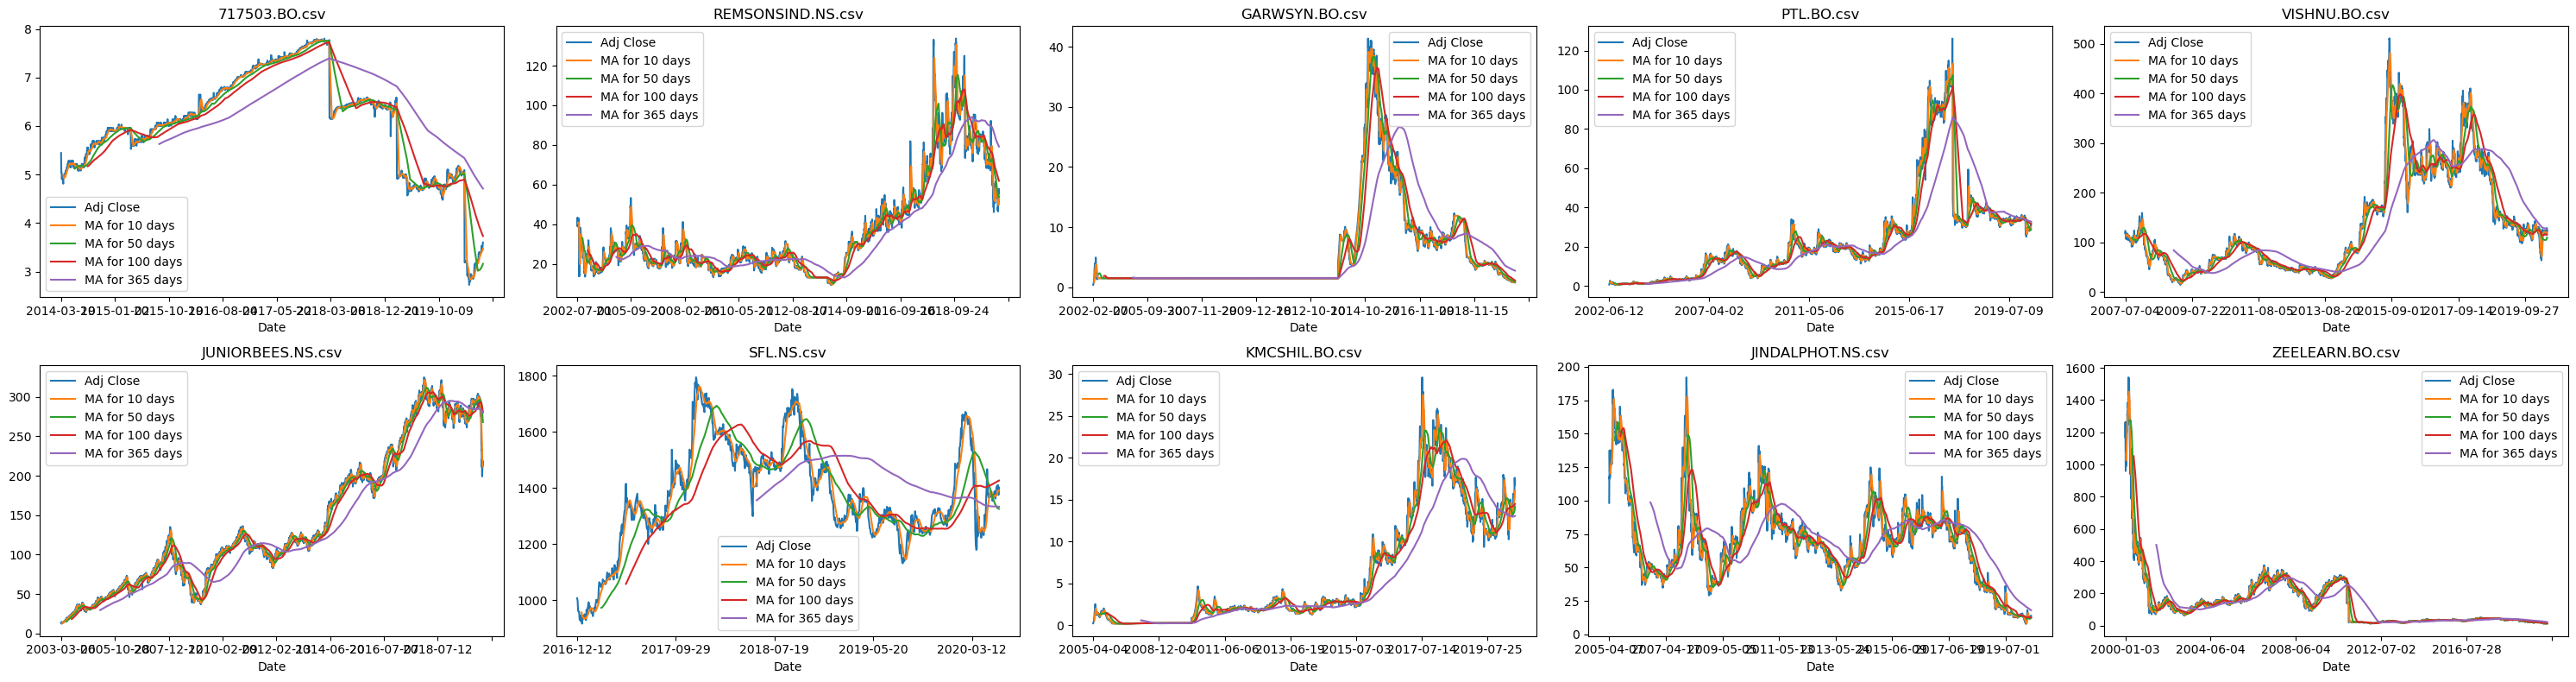

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_figheight(8)
fig.set_figwidth(30)
k = 0; j = 0;
for i in range(100,110):
    df[i][['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days','MA for 365 days']].plot(ax=axes[k,j]).set_title(f"{stock_name[i]}");
    j = j+1;
    if(j==5):
        k=1;
        j=0;
fig.tight_layout()
# linestyle = '--', marker = 'o'

In [11]:
for company in df:
    company["Daily Return"] = company["Adj Close"].pct_change()

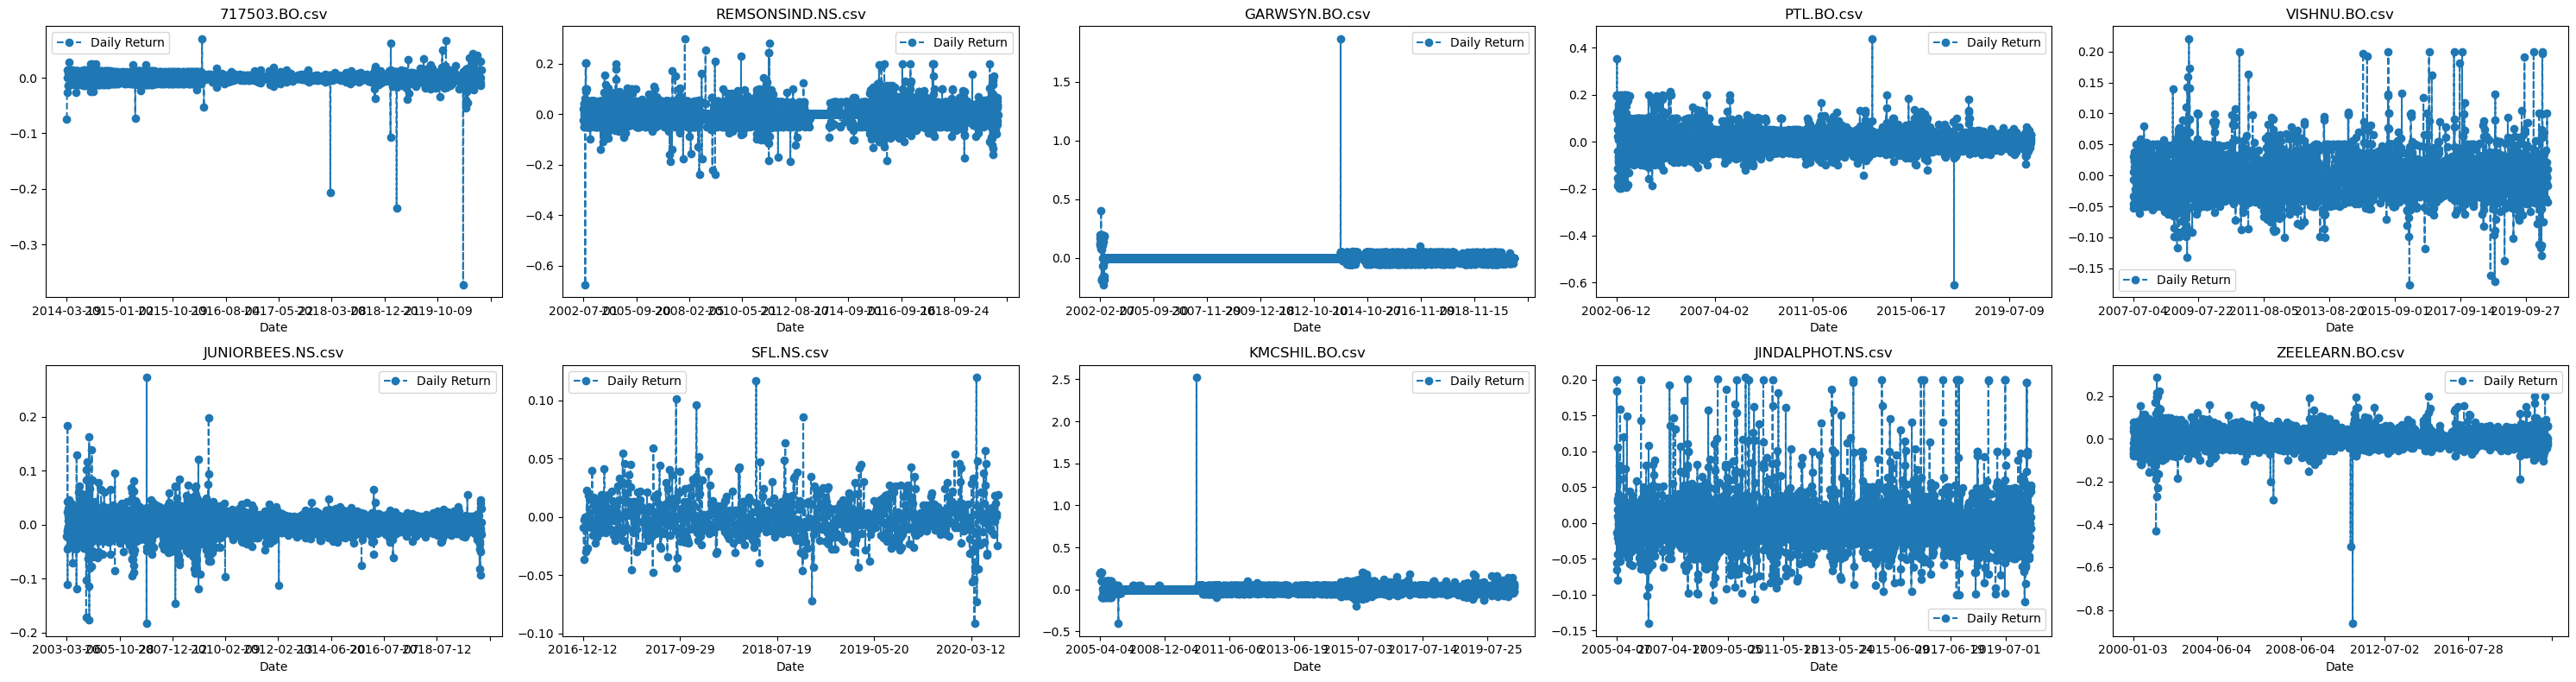

In [12]:
fig, axes = plt.subplots(nrows = 2, ncols = 5)
fig.set_figheight(8)
fig.set_figwidth(30)

k = 0
j = 0
for i in range(100, 110):
    df[i][["Daily Return"]].plot(ax = axes[k, j], linestyle = "--", marker = "o").set_title(f"{stock_name[i]}")
    j += 1
    if (j == 5):
        k = 1
        j = 0
fig.tight_layout()

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

In [14]:
def build_training_dataset(input_ds):
    # Create a new dataframe with only the 'Close column 
    input_ds.reset_index()
    data = input_ds.filter(items=['Close'])
    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return data, dataset, training_data_len

#Test the function
training_data_df, training_dataset_np, training_data_len = build_training_dataset(df[100])
dataset=training_dataset_np
data=training_data_df

In [15]:
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

#Test the function
scaler, scaled_data = scale_the_data(training_dataset_np)

In [16]:
# Create the training data set 
# Create the scaled training data set
def split_train_dataset(training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            #print(x_train)
            #print(y_train)
            print('.')
            
    # Convert to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return x_train, y_train

#Test the function
x_train,y_train = split_train_dataset(training_data_len)

.
.


In [17]:
def build_lstm_model(x_train,y_train):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    # adam ~ Stochastic Gradient descent method.
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    return model 

#Test the function
lstm_model = build_lstm_model(x_train,y_train)

1427/1427 [==============================] - 42s 27ms/step - loss: 0.0027


In [18]:
##import pickle
##pickle.dump(lstm_model, open(stock_name[100], 'wb'))

In [19]:
def create_testing_data_set(model, scaler, training_data_len,test_data_len):
    # Create the testing data set
    # Create a new array containing scaled values from index 1543 to 2002 
    test_data = scaled_data[training_data_len - test_data_len: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(test_data_len, len(test_data)):
        x_test.append(test_data[i-test_data_len:i, 0])
    
    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    rmse
    return (x_test, y_test, predictions, rmse)

#Test the function
TEST_DATA_LENGTH = 100
x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH)

ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 60, 1), found shape=(None, 100, 1)


In [ ]:
def plot_predictions(stock, data,training_data_len):
    #Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,6))
    title = stock + ' Model Forecast'
    ylabel = stock + ' Close Price'
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Training Data', 'Validated Data', 'Predicted Data'], loc='lower right')
    plt.show()
    return valid
    
#Test the function
valid = plot_predictions(stock_name[100],data,training_data_len)

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
i = 0
TEST_DATA_LENGTH = 111
error_scores = {}
trained_model = {}
for stock in stock_name:
    df= df[i]
    df[i].dropna(inplace=True)
    i= i+1
    training_data_df, training_dataset_np, training_data_len = build_training_dataset(df) #Build the Training Dataset
    dataset=training_dataset_np
    data=training_data_df
    scaler, scaled_data = scale_the_data(training_dataset_np) #Scale the data
    x_train,y_train = split_train_dataset(training_data_len) #split the data
    lstm_model = build_lstm_model(x_train,y_train) #build the LSTM model
    trained_model[stock] = lstm_model
    x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH ) #create testing dataset and predictions
    valid = plot_predictions(stock,data,training_data_len) #plot predictions
    valid   # Show the valid and predicted prices
    rmse = sqrt(mean_squared_error(valid['Close'], valid['Predictions']))
    print('Test RMSE: %.3f' % (rmse))
    #error_scores.append(rmse)
    error_scores[stock] = rmse

print(error_scores)